# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from os import listdir as LD, makedirs as MDs
from os.path import join as PJ, basename as PBN, dirname as PDN, exists as PE
import pandas as pd
from datetime import datetime as DT

In [2]:
from imod import msw
from imod import mf6
import primod

In [3]:
import WS_Mdl.utils as U
import WS_Mdl.utils_imod as UIM

In [4]:
import importlib as IL
IL.reload(U)
IL.reload(UIM)

<module 'WS_Mdl.utils_imod' from 'C:\\Users\\Karam014\\OneDrive - Universiteit Utrecht\\WS_Mdl\\code\\WS_Mdl\\utils_imod.py'>

In [5]:
# Import sfrmaker and other necessary packages for SFR network creation
import sfrmaker as sfr
import geopandas as gpd
import numpy as np

In [6]:
import fiona

In [7]:
sfr.__version__

'0.12.1'

In [8]:
from WS_Mdl.utils import bold, bold_off

# Options

In [9]:
Pa_GPkg = r"C:\OD\WS_Mdl\models\NBr\PrP\SFR\BrabantseDelta\acceptatiedatabase.gdb"

In [10]:
MdlN = 'NBr33'

In [11]:
U.set_verbose(False)

In [12]:
# Load paths and variables from PRJ & INI
d_Pa = U.get_MdlN_Pa(MdlN)
Pa_PRJ = d_Pa['PRJ']
Dir_PRJ = PDN(Pa_PRJ)
d_INI = U.INI_to_d(d_Pa['INI'])
Xmin, Ymin, Xmax, Ymax = [float(i) for i in d_INI['WINDOW'].split(',')]
SP_date_1st, SP_date_last = [DT.strftime(DT.strptime(d_INI[f'{i}'], '%Y%m%d'), '%Y-%m-%d') for i in ['SDATE', 'EDATE']]
dx = dy = float(d_INI['CELLSIZE'])

# Load GPkg. Select correct layer. Limit to Mdl Aa.

After this methodology is established, a function should be created that'll take in either a GeoPackage with a specified layer or a shapefile (single layer).<br>
Other Params like the Cols to be used for the SFR network creation, should be provided as well. A .toml file could be a good idea.

In [13]:
# First, let's see what layers are available in the GeoPackage
layers = fiona.listlayers(Pa_GPkg)
print("Available layers in GeoPackage:")
for i, layer in enumerate(layers):
    print(f"  {i+1}. {layer}")

Available layers in GeoPackage:
  1. gemaal
  2. brug
  3. DuikerSifonHevel
  4. afsluitmiddel
  5. LEGGER_VASTGESTELD_WATERLOOP_CATEGORIE_A
  6. hydroobject
  7. stuw
  8. sturing
  9. vispassage


In [14]:
# Read the hydroobject layer specifically
GDF = gpd.read_file(Pa_GPkg, layer='hydroobject')

In [15]:
print(f"\nHydroobject layer loaded successfully!\nNumber of features: {bold}{len(GDF)}{bold_off}\nCRS: {bold}{GDF.crs}{bold_off}\nGeometry types: {GDF.geometry.geom_type.value_counts()}")
print(*GDF.columns, sep=' | ')


Hydroobject layer loaded successfully!
Number of features: 40811
CRS: EPSG:28992
Geometry types: MultiLineString    40811
Name: count, dtype: int64
CODE | NAAM | STATUSLEGGERWATERSYSTEEM | STATUSOBJECT | DRAINEERT | GETIJDEBEINVLOED | RUIMTELIJKEAFBAKENINGBEKEND | NAMESPACE | DETAILNIVEAUGEOMETRIE | LVPUBLICATIEDATUM | CREATED_USER | CREATED_DATE | LAST_EDITED_USER | LAST_EDITED_DATE | WS_BRONINWINNING | WS_DATUMINWINNING | WS_PRECISIE | WS_IDEALISATIE | WS_BETROUWBAARHEID | WS_CALAMITEITENPLAN | WS_KWALITEITSLABEL | WS_HYDROOBJECT_SOORT | WS_BH_BOVENSTROOMS | WS_BH_BENEDENSTROOMS | WS_HGT_MAAIVELD_BOVS | WS_HGT_MAAIVELD_BENS | WS_INDICATIE_SCHOUW_L | WS_WIJZEINWINNING | WS_HGT_BESCHOEIING_LINKS | WS_HGT_BESCHOEIING_RECHTS | WS_HGT_ONDERK_BES_LINKS | WS_HGT_ONDERK_BES_RECHTS | WS_HGT_INSTEEK_LINKERZIJDE | WS_HGT_INSTEEK_RECHTERZIJDE | WS_OPMERKING_L | WS_HGT_INSTEEK_LI_L | WS_HGT_INSTEEK_RE_L | WS_BHGT_ACCPROF_LI_L | WS_BHGT_ACCPROF_RE_L | WS_ONDERWATERTALUD_LI_L | WS_ONDERWATERTALUD_

In [16]:
GDF.head(3)

,CODE,NAAM,STATUSLEGGERWATERSYSTEEM,STATUSOBJECT,DRAINEERT,GETIJDEBEINVLOED,RUIMTELIJKEAFBAKENINGBEKEND,NAMESPACE,DETAILNIVEAUGEOMETRIE,LVPUBLICATIEDATUM,...,ONTSTAANSWIJZE,DATUMINWINNING,INWINNENDEINSTANTIE,METENDEINSTANTIE,INWINNINGSMETHODE,DIMENSIE,NAUWKEURIGHEIDXY,NAUWKEURIGHEIDZ,SHAPE_Length,geometry
0,OWL14602,Onbekend,4.0,3.0,NaN,None,None,None,NaN,NaT,...,NaN,NaT,None,None,NaN,NaN,NaN,NaN,253.308288,"MULTILINESTRING ((85136.766 396597.503, 85131...."
1,OWL20045,Onbekend,1.0,3.0,NaN,None,None,None,NaN,NaT,...,NaN,NaT,None,None,NaN,NaN,NaN,NaN,182.535567,"MULTILINESTRING ((100018.116 384285.028, 10001..."
2,OWL16386,Onbekend,1.0,3.0,NaN,None,None,None,NaN,NaT,...,NaN,NaT,None,None,NaN,NaN,NaN,NaN,153.199875,"MULTILINESTRING ((100582.34 384508.938, 100583..."


In [17]:
GDF.describe(include='all')

,CODE,NAAM,STATUSLEGGERWATERSYSTEEM,STATUSOBJECT,DRAINEERT,GETIJDEBEINVLOED,RUIMTELIJKEAFBAKENINGBEKEND,NAMESPACE,DETAILNIVEAUGEOMETRIE,LVPUBLICATIEDATUM,...,ONTSTAANSWIJZE,DATUMINWINNING,INWINNENDEINSTANTIE,METENDEINSTANTIE,INWINNINGSMETHODE,DIMENSIE,NAUWKEURIGHEIDXY,NAUWKEURIGHEIDZ,SHAPE_Length,geometry
count,40791,39139,40060.000000,40424.000000,0.0,979,6,0,0.0,0,...,6.0,0,0,0,0.0,0.0,0.0,0.0,40811.000000,40811
unique,40752,3885,NaN,NaN,NaN,2,2,0,NaN,NaN,...,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,40810
top,OVK10006,Onbekend,NaN,NaN,NaN,n,j,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MULTILINESTRING ((130009.26700000092 392638.41...
freq,3,24297,NaN,NaN,NaN,978,5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
mean,NaN,NaN,1.286670,3.040397,NaN,NaN,NaN,NaN,NaN,NaT,...,2.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,283.421513,NaN
min,NaN,NaN,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaT,...,2.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,0.690903,NaN
25%,NaN,NaN,1.000000,3.000000,NaN,NaN,NaN,NaN,NaN,NaT,...,2.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,106.022157,NaN
50%,NaN,NaN,1.000000,3.000000,NaN,NaN,NaN,NaN,NaN,NaT,...,2.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,208.817862,NaN
75%,NaN,NaN,1.000000,3.000000,NaN,NaN,NaN,NaN,NaN,NaT,...,2.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,369.472678,NaN
max,NaN,NaN,5.000000,99.000000,NaN,NaN,NaN,NaN,NaN,NaT,...,2.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,28611.715573,NaN


In [18]:
#666 columns need to be reviewed later!!!

The columns we're going to use are:
1. code: as unique ID.
2. 

Plot of line geometry in the whole area.


<Axes: >

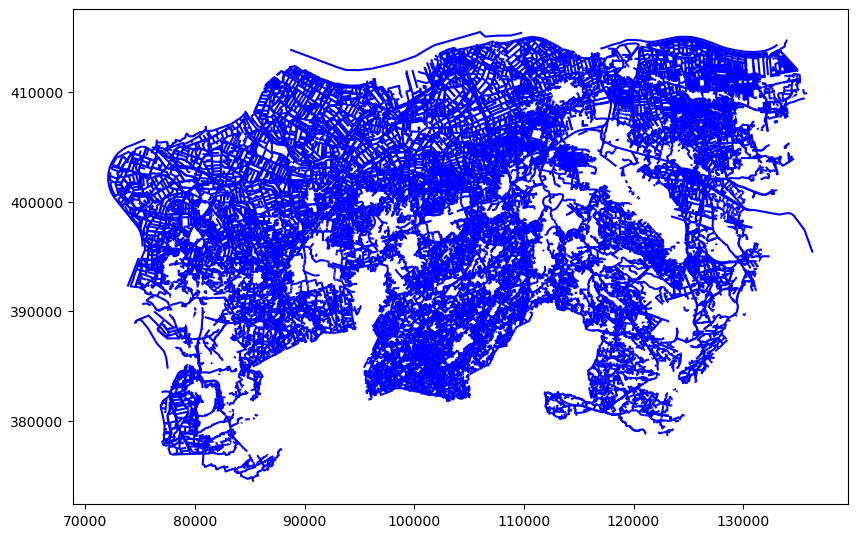

In [19]:
print('Plot of line geometry in the whole area.')
GDF.plot(figsize=(10, 10), color='blue', edgecolor='black')

In [20]:
# Limit GDF to model area bounds
print(f"Original dataset: {bold}{len(GDF):,}{bold_off} features | Bounds: {GDF.total_bounds}")
print(f"Model area bounds: Xmin: {Xmin}, Xmax: {Xmax} | Ymin: {Ymin}, Ymax: {Ymax}")

# Create bounding box for clipping
from shapely.geometry import box
model_bbox = box(Xmin, Ymin, Xmax, Ymax)

# Filter GDF to model area using spatial intersection
GDF_clipped = GDF[GDF.geometry.intersects(model_bbox)].copy()

print(f"Filtered dataset: {bold}{len(GDF_clipped):,}{bold_off} features | Bounds: {GDF_clipped.total_bounds}")
print(f"Reduction: {bold}{len(GDF)-len(GDF_clipped):,}{bold_off} features removed ({(len(GDF)-len(GDF_clipped))/len(GDF)*100:.1f}%) | ✓ GDF updated to model area extent")
print(f"✓ Network length: {GDF.geometry.length.sum()/1000:.1f} km within model area")

# Update GDF to use the clipped version
GDF = GDF_clipped

Original dataset: 40,811 features | Bounds: [ 72084.4984 374439.429  136342.416  415470.5641]
Model area bounds: Xmin: 113100.0, Xmax: 125100.0 | Ymin: 387600.0, Ymax: 396200.0
Filtered dataset: 2,362 features | Bounds: [112846.651  387082.9701 126531.775  396675.632 ]
Reduction: 38,449 features removed (94.2%) | ✓ GDF updated to model area extent
✓ Network length: 11566.7 km within model area


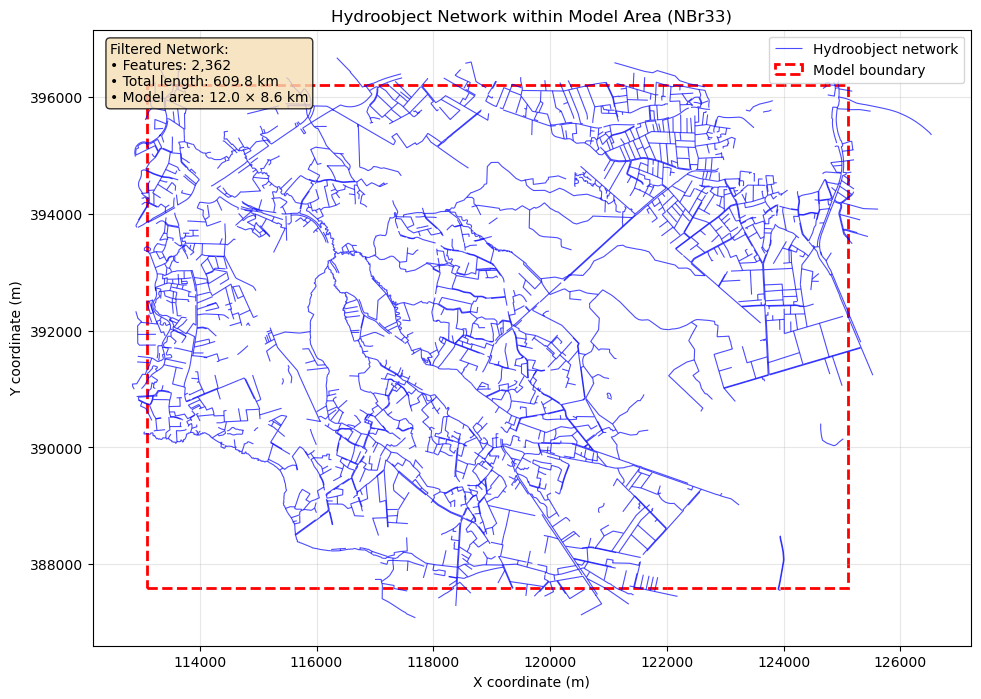

In [21]:
# Plot the filtered hydroobject network within model area
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the filtered GDF
GDF.plot(ax=ax, color='blue', linewidth=0.8, alpha=0.7, label='Hydroobject network')

# Add model boundary rectangle
from matplotlib.patches import Rectangle
model_rect = Rectangle((Xmin, Ymin), Xmax-Xmin, Ymax-Ymin, 
                      linewidth=2, edgecolor='red', facecolor='none', 
                      linestyle='--', label='Model boundary')
ax.add_patch(model_rect)

ax.set_title(f'Hydroobject Network within Model Area ({MdlN})')
ax.set_xlabel('X coordinate (m)')
ax.set_ylabel('Y coordinate (m)')
ax.legend()

# Add statistics text
stats_text = f"""Filtered Network:
• Features: {len(GDF):,}
• Total length: {GDF.geometry.length.sum()/1000:.1f} km
• Model area: {(Xmax-Xmin)/1000:.1f} × {(Ymax-Ymin)/1000:.1f} km"""

ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Add grid
ax.grid(True, alpha=0.3)

# Create Grid and Generate SFR Routing Network

In [22]:
SFR_lines = sfr.Lines.from_dataframe(GDF,
                                     crs=GDF.crs,)

AssertionError: No routing information found; dataframe column 'toid' doesn't exist.